In [3]:


from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import Compose, Invertd, SaveImaged
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
import torch
import json


In [4]:
config_file = '/students/2023-2024/master/Shahpouri/DL_PET/config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']

In [20]:
from data_preparation import DataHandling 

data_handler = DataHandling(ga_data_dir, train_mode="NAC", target_mode="MAC")

train_files = data_handler.get_data_split('train')
val_files = data_handler.get_data_split('val')
test_files = data_handler.get_data_split('test')
print(len(train_files))
print(len(val_files))
print(len(test_files))

from data_preparation import LoaderFactory
loader_factory = LoaderFactory(
    train_files=train_files,
    val_files=val_files,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27], # For fdg data
    spatial_size = (168, 168, 320)
    # spatial_size = (336, 336, 640) # for Fdg data
    )

test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)
val_loader = loader_factory.get_loader('val', batch_size=1, num_workers=2, shuffle=False)
train_loader = loader_factory.get_loader('train', batch_size=1, num_workers=2, shuffle=False)



129
33
20


Loading dataset:   0%|          | 0/129 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 129/129 [01:02<00:00,  2.06it/s]


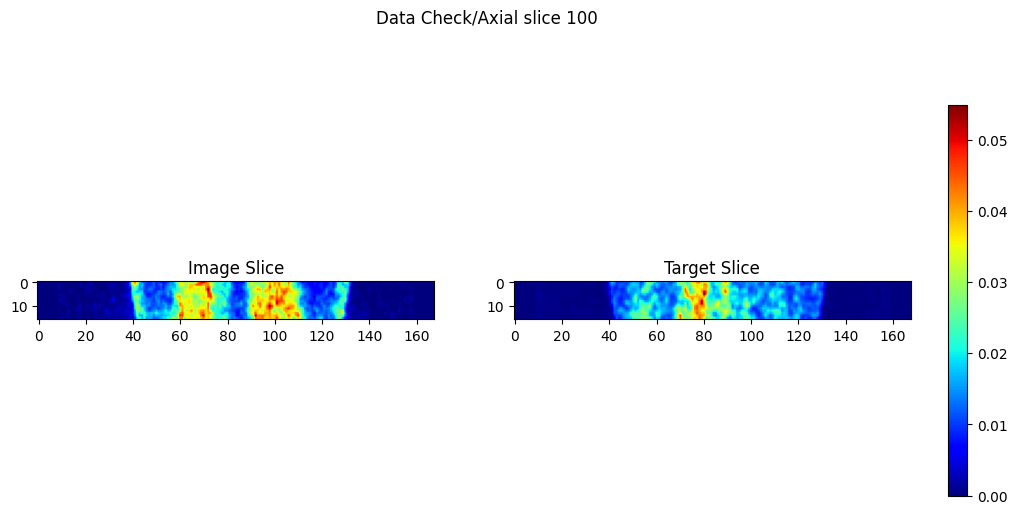

In [22]:
from data_preparation import visualize_axial_slice, visualize_axial_slice2


slice_index = 100  # Example slice index.
visualize_axial_slice2(train_loader, slice_index)

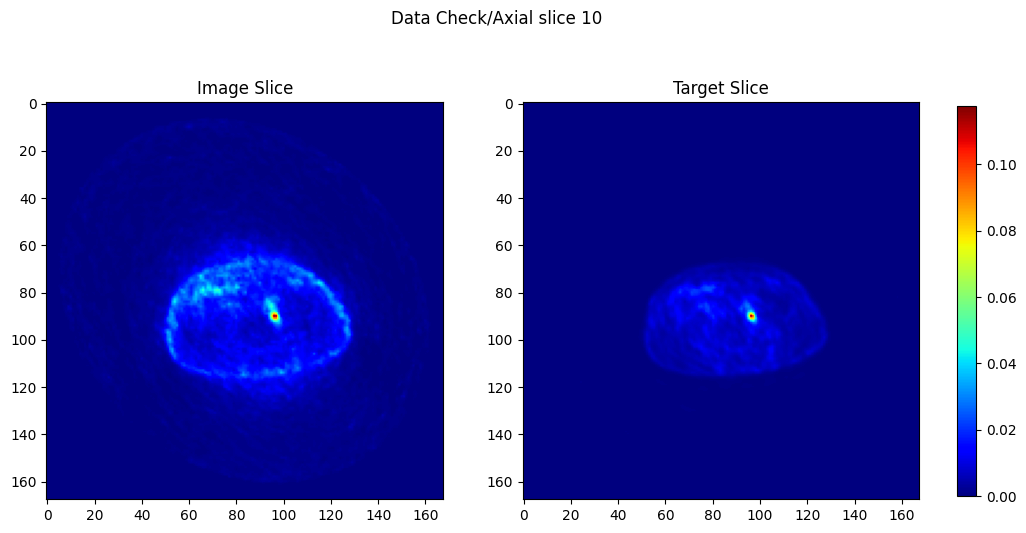

In [27]:

    
slice_index = 10 # Example slice index.
visualize_axial_slice(train_loader, slice_index)